In [6]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from plotly import tools
import plotly.graph_objs as go

Implement a P controller by running 100 iterations of robot motion. The desired trajectory for the robot is the x-axis. The steering angle should be set by the parameter tau so that:
 
<p align="center">** steering=-tau*crosstrack_error **</p>


In [7]:
# this is the robot class
class Robot(object):
    def __init__(self,length=20.0):
        """
        creates robot and initializes location/orientation to 0,0,0.
        """
        self.x=0.0
        self.y=0.0
        self.orientation=0.0
        self.length=length
        self.steering_noise=0.0
        self.distance_noise = 0.0
        self.steering_drift=0.0
    def set(self,x,y,orientation):
        """
        set a robot coordinate
        """
        self.x=x
        self.y=y
        self.orientation=orientation %(2.0*np.pi)
    def set_noise(self,steering_noise,distance_noise):
        """
        make it possible to change the noise parameters
        this is often useful in particle filter
        """
        self.steering_noise=steering_noise
        self.distance_noise=distance_noise
    def set_steering_drift(self,drift):
        """
        sets the systematical steering drift parameter
        """
        self.steering_drift=drift
    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

        def __repr__(self):
            return '[x=%.5f y=%.5f orie=%.5f]' %(self.x,self.y,self.orientation)
        
    

In [8]:
def run(robot,tau,n=200,speed=1.0):
    x_trajectory=[]
    y_trajectory=[]
    for i in range(n):
        cte=robot.y
        steer=-tau*cte
        robot.move(steer,speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory,y_trajectory

    

# Implement P Controller

In [9]:
robot=Robot()
robot.set(0,1,0)
robot.y

1

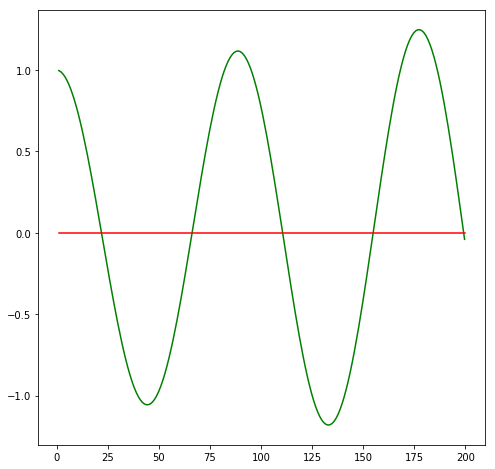

In [10]:
P_x_trajectory,P_y_trajectory=run(robot,0.1)
n=len(P_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))


ax1.plot(P_x_trajectory,P_y_trajectory,'g',label='P Controller')
ax1.plot(P_x_trajectory,np.zeros(n),'r',label='Reference')

### Implement P Controller with a Tau of 0.3

In [11]:
robot=Robot()
robot.set(0,1,0)
robot.y

1

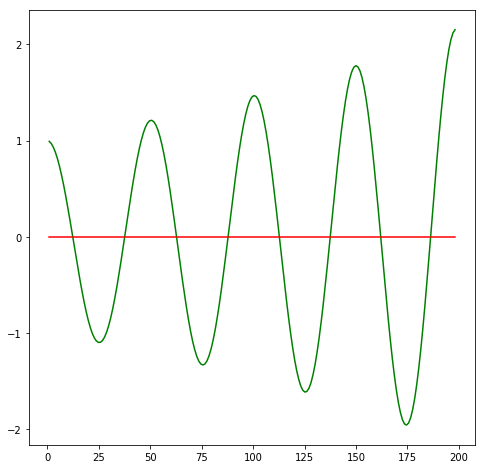

In [12]:
P_x_trajectory,P_y_trajectory=run(robot,0.3)
n=len(P_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))
ax1.plot(P_x_trajectory,P_y_trajectory,'g',label='P Controller')
ax1.plot(P_x_trajectory,np.zeros(n),'r',label='Reference')

# Implement PD Controller

In [13]:
robot=Robot()
robot.set(0,1,0)
robot.y


1

In [14]:
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)

def run(robot,tau_p,tau_d,n=200,speed=1.0):
    x_trajectory=[]
    y_trajectory=[]
    prev_cte = robot.y
    for i in range(n):
        cte=robot.y
        diff_CTE=cte-prev_cte
        prev_cte = cte
        steer=-tau_p*cte- tau_d* diff_CTE

        robot.move(steer,speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory,y_trajectory

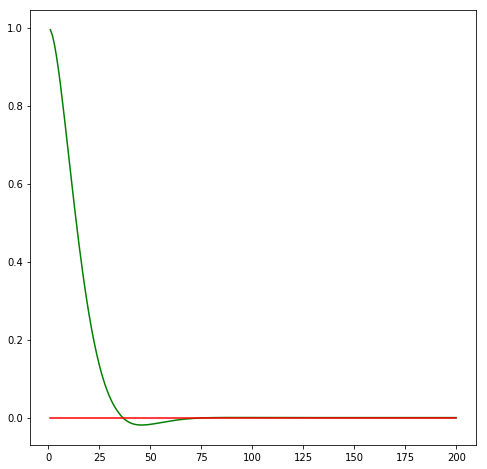

In [15]:
PD_x_trajectory,PD_y_trajectory=run(robot,0.2, 3.0)
n=len(PD_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))
ax1.plot(PD_x_trajectory,PD_y_trajectory,'g',label='P Controller')
ax1.plot(PD_x_trajectory,np.zeros(n),'r',label='Reference')

# Implement Systematic Bias

In [16]:
#To solve the systematic bias problem, I'm now adding a line that sets the steering drift to be 10 degrees 
robot=Robot()
robot.set(0,1,0)
robot.set_steering_drift(10.0/180.0*np.pi)
robot.y


1

In [17]:
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)

def run(robot,tau_p,tau_d,n=200,speed=1.0):
    x_trajectory=[]
    y_trajectory=[]
    prev_cte = robot.y
    for i in range(n):
        cte=robot.y
        diff_CTE=cte-prev_cte
        prev_cte = cte
        steer=-tau_p*cte- tau_d* diff_CTE

        robot.move(steer,speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory,y_trajectory

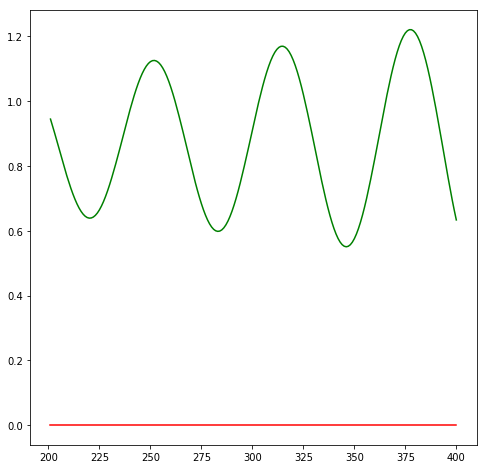

In [19]:
#change tau_d to 3

SysB_x_trajectory,SysB_y_trajectory=run(robot,0.2, 0)
n=len(SysB_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))
ax1.plot(SysB_x_trajectory,SysB_y_trajectory,'g',label='Systematic Bias')
ax1.plot(SysB_x_trajectory,np.zeros(n),'r',label='Reference')

# PID implementation

In [20]:
#To solve the systematic bias problem, I'm now adding a line that sets the steering drift to be 10 degrees 
robot=Robot()
robot.set(0,1,0)
robot.set_steering_drift(10.0/180.0*np.pi)
robot.y

1

With the integral term we're keeping track of all the previous CTEs, initially we set int_cte to 0 and then add the current cte term to the count int_cte += cte. Finally we update the steering value, -tau_p * cte - tau_d * diff_cte - tau_i * int_cte with the new tau_i parameter.


In [21]:

def run1(robot,tau_p,tau_d,tau_i,n=200,speed=1.0):
    x_trajectory=[]
    y_trajectory=[]
    prev_cte = robot.y
    int_cte =0
    for i in range(n):
        cte=robot.y
        diff_CTE=cte-prev_cte
        prev_cte = cte
        int_cte +=cte
        steer=-tau_p*cte- tau_d* diff_CTE-tau_i*int_cte
        robot.move(steer,speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory,y_trajectory

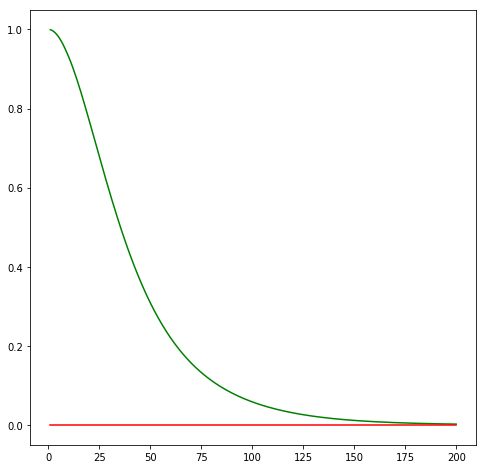

In [22]:
#change tau_d to 3

pid_x_trajectory,pid_y_trajectory=run1(robot,0.2, 3.0,0.004)
n=len(pid_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))
ax1.plot(pid_x_trajectory,pid_y_trajectory,'g',label='P Controller')
ax1.plot(pid_x_trajectory,np.zeros(n),'r',label='Reference')

# Parameter Optimization Solution

In [23]:
def make_robot():
    robot=Robot()
    robot.set(0,1,0)
    robot.set_steering_drift(10.0/180.0*np.pi)
    robot.y
    return robot

In [24]:
#change run based on the vectors
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

In [25]:
def twiddle(tol=0.2): 
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p

In [26]:
p=twiddle(tol=0.2)

Iteration 0, best error = 8315.955485215645
Iteration 1, best error = 0.0434970807256939
Iteration 2, best error = 0.03065437362443958
Iteration 3, best error = 0.007677320020068962
Iteration 4, best error = 0.003220167427116315
Iteration 5, best error = 0.0016645945527960435
Iteration 6, best error = 0.0009761080831682494
Iteration 7, best error = 0.0006163432367765914
Iteration 8, best error = 0.00041102748054356214
Iteration 9, best error = 0.0001987737410103838
Iteration 10, best error = 1.176902590931792e-06
Iteration 11, best error = 7.050884269315375e-07
Iteration 12, best error = 1.379736668887161e-12
Iteration 13, best error = 1.379736668887161e-12
Iteration 14, best error = 1.379736668887161e-12
Iteration 15, best error = 1.0756081254419683e-12
Iteration 16, best error = 1.0756081254419683e-12
Iteration 17, best error = 1.0756081254419683e-12
Iteration 18, best error = 8.12857772854578e-13
Iteration 19, best error = 8.12857772854578e-13
Iteration 20, best error = 8.1285777285

In [27]:
print(p)


[2.9331227688652457, 10.326589894591526, 0.49316041639454505]


In [28]:
twiddle_x_trajectory,twiddle_y_trajectory=run1(robot,2.9331227688652457, 10.326589894591526, 0.49316041639454505)

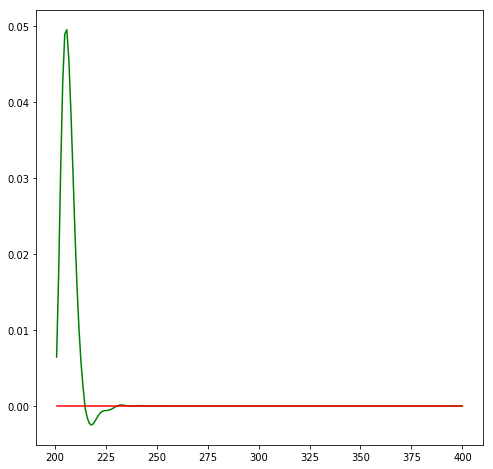

In [30]:
n=len(twiddle_x_trajectory)
fig, ax1=plt.subplots(1,1,figsize=(8,8))
ax1.plot(twiddle_x_trajectory,twiddle_y_trajectory,'g',color='green',label='twiddle ')

ax1.plot(twiddle_x_trajectory,np.zeros(n),'r',label='Reference')


In [37]:
fig = go.Figure()
fig.add_trace(go.Line(x=P_x_trajectory, y=P_y_trajectory,name="P Controller"))
fig.add_trace(go.Line(x=PD_x_trajectory,y=PD_y_trajectory,name="PD Controller"))
fig.add_trace(go.Line(x=pid_x_trajectory,y=pid_y_trajectory,name="PID Controller"))
fig.add_trace(go.Line(x=SysB_x_trajectory,y=SysB_y_trajectory,name="Systematic Bias"))

fig.add_trace(go.Line(x=twiddle_x_trajectory,y=twiddle_y_trajectory,name="Parameter Optimization"))
fig.add_trace(go.Line(x=twiddle_x_trajectory,y=np.zeros(n),name="Reference"))



fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink',)
#fig.update_xaxes(tickvals=x)
    
fig.update_layout( autosize=True,xaxis_title="Cross Track Error", yaxis_title="Amount")

fig.show()

C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


